# Demo
A demonstration notebook showing off how to use the `dmv.data.DataContainer` and the `dmv.layer.DynamicMultiViewRNN`.

In [17]:
import os
import datetime
import seaborn as sb
import numpy as np
import random
import matplotlib.pyplot as plt 
%matplotlib inline

import tensorflow as tf
import tensorflow_addons as tfa

tf.keras.backend.set_floatx('float32')
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
!nvidia-smi

Fri Oct 16 16:56:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0  On |                  N/A |
|  6%   54C    P5    16W / 151W |   7908MiB /  8118MiB |     25%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [19]:
from pathlib import Path

base_folder = Path('/') / 'home' / 'jeroen' / 'Documents' / 'Study' / 'Capita'
data_folder = base_folder / 'data' / 'full'
log_folder = base_folder / 'logs' / 'exploration'

print(f'Tensorboard logs available on: {log_folder}')

multi = True
img_shape = [128, 128, 3]

Tensorboard logs available on: /home/jeroen/Documents/Study/Capita/logs/exploration


In [20]:
train_augmentation = {
    'rotation': 30,
    'horizontal_flip': True,
}

In [21]:
from dmv.data import DataContainer

common = {
    'category': 'Humerus',
    'batch_size': 4 if multi else 8,
    'output_shape': img_shape,
    'cache_imgs': True
}

train_dc = DataContainer(data_folder, multi=multi, train=True, augmentation=train_augmentation, **common)
valid_dc = DataContainer(data_folder, multi=True, train=False, **common)

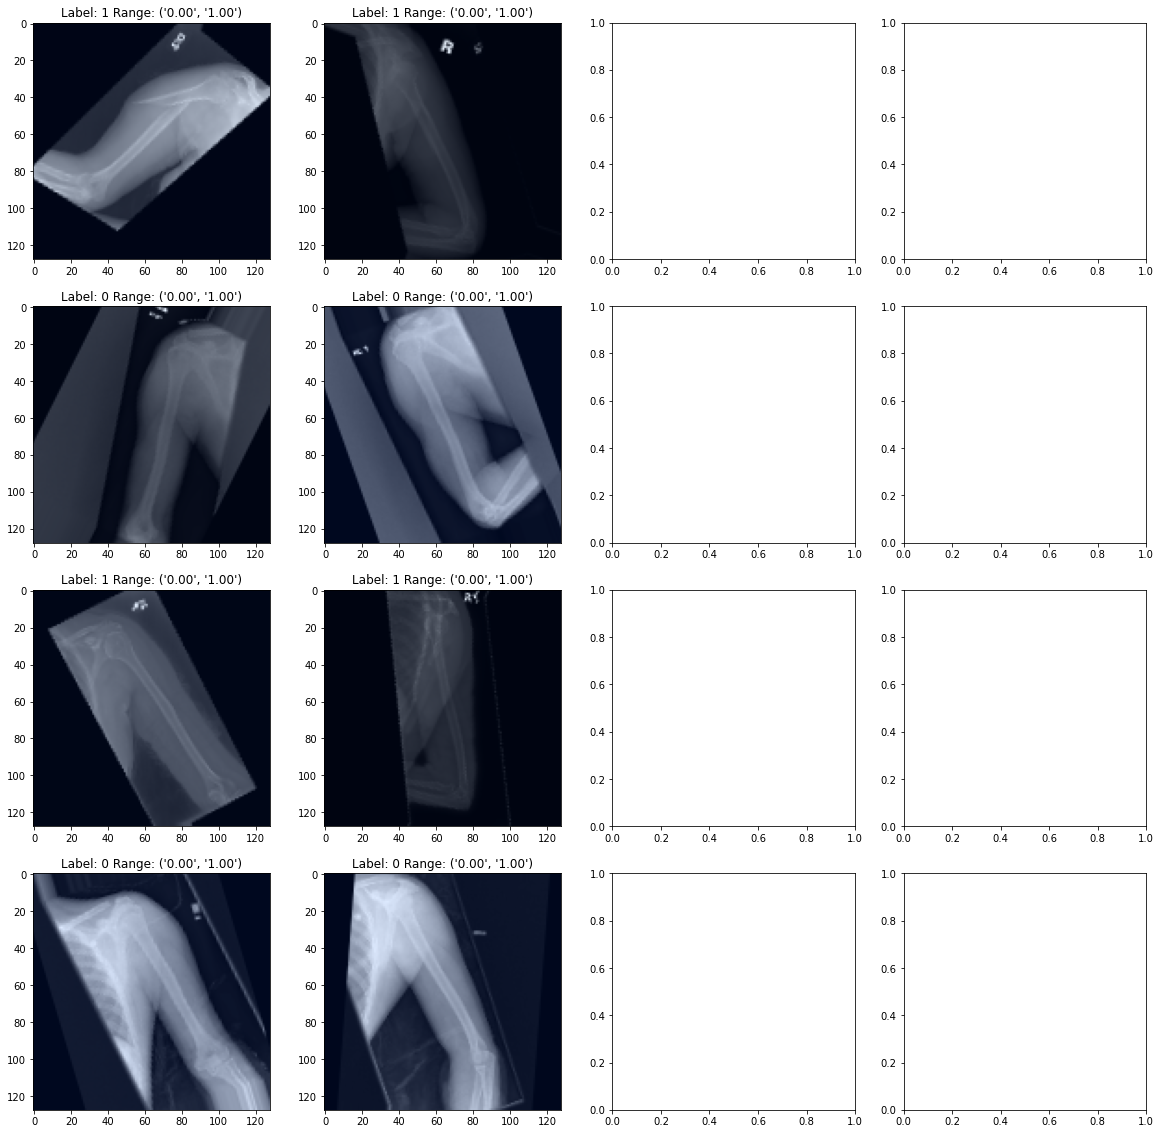

In [22]:
train_dc.show(figsize=(20,20))

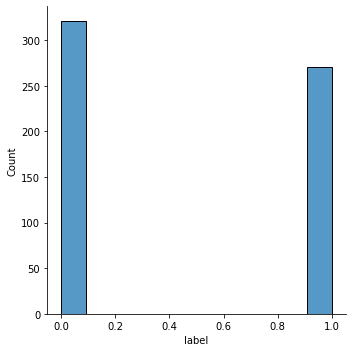

In [23]:
_ = sb.displot(train_dc.df, x='label')

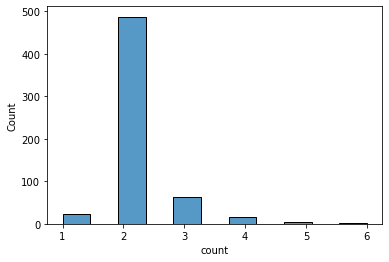

In [24]:
if multi:
    pdf = train_dc.df
    pdf['count'] =pdf['file'].str.len()
    sb.histplot(pdf, x='count')

## Model

In [25]:
from tensorflow.keras.applications import DenseNet169, DenseNet121
from dmv.dense import DenseNet121 as SplittedDenseNet121, dense_block
from tensorflow.keras.layers import Dense, TimeDistributed, Flatten, Dropout, Input, BatchNormalization, Reshape, Activation, GlobalAveragePooling2D, Layer, AbstractRNNCell, RNN
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2

from dmv.layer import DynamicMultiViewRNN, DynamicMultiViewRNN2D, Mask

class DynamicMultiViewModel(Model):
    def __init__(self, num_classes, input_shape, alpha=0.0002):
        super().__init__()
        
        dense, inputs, intermediate, out = SplittedDenseNet121(include_top=False, input_shape=input_shape, pooling='avg')
        self.base = Model(inputs, intermediate, name='densenet_head')
#         for layer in self.base.layers[:-30]:
#             layer.trainable = False
#         for layer in self.base.layers[-30:]:
#             layer.trainable = True
        for layer in self.base.layers:
            layer.trainable = True

        self.agg = DynamicMultiViewRNN()
        
        tail_input = Input(shape=self.base.output_shape[-3:])
        tail_x = dense_block(tail_input, 16, name='conv5')
        tail_x = BatchNormalization(axis=3, epsilon=1.001e-5, name='bn')(tail_x)
        tail_x = Activation('relu', name='relu')(tail_x)
        tail_x = GlobalAveragePooling2D(name='avg_pool')(tail_x)
        self.tail = Model(tail_input, tail_x, name='densenet_tail')
        
        for layer in self.tail.layers:
            if 'input' not in layer.name:
                dense_weights = dense.get_layer(layer.name).get_weights()
                layer.set_weights(dense_weights)
            
            layer.trainable = True
        
        self.batchnorm = BatchNormalization()
        self.dropout_1 = Dropout(.5)
        self.dense = Dense(10, activation='relu', name='dense')
        self.dropout = Dropout(.5)
        self.classify = Dense(num_classes, activation='sigmoid', name='classify')
        
        regularizer = l2(alpha / 2)
        for layer in self.base.layers + self.tail.layers + [self.dense, self.classify]:
            for attr in ['kernel_regularizer', 'bias_regularizer']:
                if hasattr(layer, attr) and layer.trainable:
                    setattr(layer, attr, regularizer)
    
    def call(self, x):
        x = TimeDistributed(self.base)(x)
        x = TimeDistributed(Flatten())(x)
        x = self.agg(x)
        x = Reshape(self.base.output_shape[-3:])(x)
        x = self.tail(x)
        
        x = self.batchnorm(x)
        x = self.dropout_1(x)
        x = self.dense(x)
        x = self.dropout(x)
        x = self.classify(x)

        return x

In [26]:
class MultiViewModel(Model):
    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.base = DenseNet121(include_top=False, input_shape=input_shape, pooling='avg')
        for index, layer in enumerate(self.base.layers):
            layer.trainable = True
        
        self.classify = Dense(num_classes, activation='sigmoid', name='classify')
        self.masker = Mask()
        
        self.agg = DynamicMultiViewRNN(aggregation_type='mean')
    
    def call(self, x):
        y = x
        
        x = TimeDistributed(self.base)(x)
        x = TimeDistributed(self.classify)(x)
        
        y = TimeDistributed(self.masker)(y)
        
        x = self.agg((x, y))
        
        return x

In [27]:
from dmv.models import MultiEvalModel

class SingleViewModel(MultiEvalModel):
    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.base = DenseNet121(include_top=False, input_shape=input_shape, pooling='avg')
        for index, layer in enumerate(self.base.layers):
            layer.trainable = True
        
        self.classify = Dense(num_classes, activation='sigmoid', name='classify')
    
    def call(self, x):
        x = self.base(x)
        x = self.classify(x)
        
        return x

In [28]:
from tensorflow.keras.metrics import Accuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow_addons.metrics import CohenKappa

metrics = [
    CohenKappa(name='cohen-kappa', num_classes=2),
    TruePositives(name='true-pos'),
    TrueNegatives(name='true-neg'),
    FalsePositives(name='false-pos'),
    FalseNegatives(name='false-neg')
]

In [29]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

if multi:
    model = MultiViewModel(1, train_dc._output_shape[-3:])
    
    model.build(tuple([train_dc._batch_size] + train_dc._output_shape))
    model.compile(
        optimizer=Adam(0.0001, beta_1=0.9, beta_2=0.999),
        metrics=metrics,
        loss=BinaryCrossentropy()
    )
else:
    model = SingleViewModel(1, train_dc._output_shape[-3:])
    
    model.build(tuple([train_dc._batch_size] + train_dc._output_shape))
    model.compile(
        optimizer=Adam(0.0001, beta_1=0.9, beta_2=0.999),
        metrics=metrics,
        loss=BinaryCrossentropy()
    )
        
model.summary()

Model: "multi_view_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
classify (Dense)             multiple                  1025      
_________________________________________________________________
mask_1 (Mask)                multiple                  0         
_________________________________________________________________
dynamic_multi_view_rnn_1 (Dy multiple                  0         
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


## Callbacks

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Training

In [31]:
class_weights = {
    0: len(train_dc.df[train_dc.df['label'] == 1]) / len(train_dc.df),
    1: len(train_dc.df[train_dc.df['label'] == 0]) / len(train_dc.df),
}

In [32]:
from dmv.utils import request_run_identifier

early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-4, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

log_record_dir = log_folder / ('multi' if multi else 'single') / request_run_identifier(log_folder) / datetime.datetime.now().strftime("%m-%d_%H-%M")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_record_dir, histogram_freq=1)

model.fit(
    x=train_dc.ds(),
    steps_per_epoch=train_dc.batches_per_epoch,
    validation_data=valid_dc.ds(),
    validation_steps=valid_dc.batches_per_epoch,
    epochs=50,
    class_weight=class_weights,
    callbacks=[tensorboard_callback, early_stop, reduce_lr]
)

Enter a run identifier: 


 masked-mean-128px


Epoch 1/50
148/148 [==============================] - 397s 3s/step - loss: 0.3131 - cohen-kappa: 0.2890 - true-pos: 159.0000 - true-neg: 225.0000 - false-pos: 96.0000 - false-neg: 112.0000 - val_loss: 0.5909 - val_cohen-kappa: 0.3948 - val_true-pos: 63.0000 - val_true-neg: 31.0000 - val_false-pos: 37.0000 - val_false-neg: 4.0000
Epoch 2/50
148/148 [==============================] - 14s 95ms/step - loss: 0.2828 - cohen-kappa: 0.4594 - true-pos: 193.0000 - true-neg: 240.0000 - false-pos: 81.0000 - false-neg: 78.0000 - val_loss: 0.9383 - val_cohen-kappa: 0.2340 - val_true-pos: 67.0000 - val_true-neg: 16.0000 - val_false-pos: 52.0000 - val_false-neg: 0.0000e+00
Epoch 3/50
148/148 [==============================] - 14s 96ms/step - loss: 0.2881 - cohen-kappa: 0.4810 - true-pos: 200.0000 - true-neg: 239.0000 - false-pos: 82.0000 - false-neg: 71.0000 - val_loss: 0.5796 - val_cohen-kappa: 0.5118 - val_true-pos: 57.0000 - val_true-neg: 45.0000 - val_false-pos: 23.0000 - val_false-neg: 10.0000
Ep